# Pandas vs SQL

While the size of the dataset for this exercise can easily fit in memory and all analysis code be done by simple pandas DataFrames, this notebook shows a different approach. One that's scalabale by doing the following:
1. Utilizing a SQL database to host the data and transform it as needed all using SQL.
2. Instead of reading the csv files from the zip file directly all at once, we're using an iterator that will read lines one at a time. thus we can read them in batches, send the batches to the SQL database, and move on to the next batch (this becomes relevant for when data is larger than available memory).
3. Using Indices on the database side to greatly improve data querying speed.

In [1]:
from warnings import filterwarnings

filterwarnings("ignore", category=DeprecationWarning)
from pathlib import Path
from pprint import pprint
from sqlmodel import Session
from db_engine import DB_ENGINE
import matplotlib.pyplot as plt
import pandas as pd

# a helpful predefined function to read the csv files within a zip file line by line to save memory
from helper_funcs import create_record_iterator_from_csvs_in_zip_file

# used to create the empty table defined above
from sql_models import recreate_db_tables_from_scratch

# used to read lines in batches, validate them according to the model defined above, and upload them to the SQL databae
from db_migration import migrate_records_to_db

# used to read a multi statement sql file into a python list of statements
from helper_funcs import read_sql_files

## checking data structure and creating needed table accordingly

In [2]:
zip_file_path = Path().parent / "dummy_order_data_6_months.zip"
iterator = create_record_iterator_from_csvs_in_zip_file(zip_file_path)
first_2_rows = [next(iterator) for i in range(2)]
pprint(first_2_rows)

[{'branch_uuid': 'dcecb4b3-35b9-49e5-b83f-9cb3c2231cad',
  'is_group_order': '0',
  'order_date': '2023-07-01',
  'order_uuid': '510bea1a-d467-4beb-ad6b-0ce3ecb5e303',
  'restaurant_uuid': 'a379b795-fd7a-4bd5-9c2e-70bcbba95533',
  'user_uuid': 'a6a67a63-c484-4f36-b1ab-672ba43149f2'},
 {'branch_uuid': '38453d7e-2224-11e8-924e-0242ac110011',
  'is_group_order': '0',
  'order_date': '2023-07-01',
  'order_uuid': '389aa01e-0074-4624-9092-0be598649969',
  'restaurant_uuid': '362334e4-2224-11e8-924e-0242ac110011',
  'user_uuid': 'dbd1ac1a-2039-4e4d-ac53-636b58dfd0aa'}]


we will thus create a table in the database called `orderrecord` with the following columns:
```python
class OrderRecord(SQLModel, table=True):
    order_uuid: UUID = Field(primary_key=True, unique=True)
    is_group_order: bool
    order_date: date = Field(index=False)
    user_uuid: UUID = Field(index=False)
    restaurant_uuid: UUID = Field(index=False)
    order_date_year_month: Optional[int] = Field(default=None,index=False)
```
and then we will create two clusterd indices on:
1. (`user_uuid`-`order_date_year_month`) -> to be used in the first task for overall retention rate
2. (`restaurant_uuid`-`user_uuid`-`order_date_year_month`) -> to be used in the second task for per restaurant retnetion rate

In [3]:
recreate_db_tables_from_scratch()

## migrating the data from the CSV files to the SQL database in batches

In [3]:
migrate_records_to_db(zip_file_path)

records parsed: 10000
adding 10000 to db
added 10000 to db, total rows inserted are 10000
records parsed: 20000
adding 10000 to db
added 10000 to db, total rows inserted are 20000
records parsed: 30000
adding 10000 to db
added 10000 to db, total rows inserted are 30000
records parsed: 40000
adding 10000 to db
added 10000 to db, total rows inserted are 40000
records parsed: 50000
adding 10000 to db
added 10000 to db, total rows inserted are 50000
records parsed: 60000
adding 10000 to db
added 10000 to db, total rows inserted are 60000
records parsed: 70000
adding 10000 to db
added 10000 to db, total rows inserted are 70000
records parsed: 80000
adding 10000 to db
added 10000 to db, total rows inserted are 80000
records parsed: 90000
adding 10000 to db
added 10000 to db, total rows inserted are 90000
records parsed: 100000
adding 10000 to db
added 10000 to db, total rows inserted are 100000
records parsed: 110000
adding 10000 to db
added 10000 to db, total rows inserted are 110000
record

In [4]:
indices_sql_stmts_fp = Path().parent / "sql_queries" / "base_table_indices.sql"
sql_stmts = read_sql_files(indices_sql_stmts_fp)
with Session(DB_ENGINE) as session:
    for sql_stmt in sql_stmts:
        session.exec(sql_stmt)
    session.commit()

# Overall user base retention rate

We will do the following using sql statements:
1. creation of a table that has distinct rows for the following:
    1. `user_uuid` [UUID]
    2. `year_month` [INT] -> year and month where te `user_uuid` made at least one order (in the format `%Y%m`)
    3. `prev_year_month` -> the previous year and month to the `year_month` column. this will be helpful in self joining.
    4. setting up multicolumn indices on (`user_uuid`-`year_month`) and (`user_uuid`-`prev_year_month`) columns.
3. calculating the total active users each month.
4. calculating the total active users each month with activity in the previous month.
5. using these two values we can calculate the retention rate.

In [5]:
data_transformation_first_task_sql_fp = (
    Path().parent / "sql_queries" / "data_transformation_first_task.sql"
)
sql_stmts = read_sql_files(data_transformation_first_task_sql_fp)
with Session(DB_ENGINE) as session:
    for sql_stmt in sql_stmts:
        session.exec(sql_stmt)
    session.commit()

In [6]:
data_querying_first_task_fp = (
    Path().parent / "sql_queries" / "data_querying_first_task.sql"
)
sql_stmt = read_sql_files(data_querying_first_task_fp)[0]
df_retained_users = pd.read_sql((sql_stmt), DB_ENGINE)
df_retained_users

,year_month,total_month_active_users,retained_users_count,retained_precentage
0,202308,158838,84478,0.531850
1,202309,149068,79255,0.531670
2,202310,139876,76190,0.544697
3,202311,136543,74853,0.548201
4,202312,133232,74835,0.561689


<BarContainer object of 5 artists>

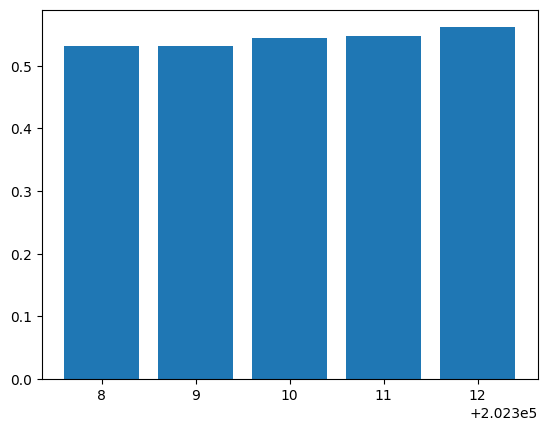

In [7]:
plt.bar(df_retained_users.year_month, df_retained_users.retained_precentage)

# Overall user base retention rate

We will do the following using sql statements:
1. creation of a table that has distinct rows for the following:
    1. `restaurant_uuid` [UUID]
    1. `user_uuid` [UUID]
    2. `year_month` [INT] -> year and month where the `user_uuid` made at least one order from `restaurant_uuid` (in the format `%Y%m`)
    3. `prev_year_month` -> the previous year and month to the `year_month` column. this will be helpful in self joining.
    4. setting up multicolumn indices on (`restaurant_uuid`-`user_uuid`-`year_month`) and (`restaurant_uuid`-`user_uuid`-`prev_year_month`) columns.
3. calculating the total active users each mont for each restaurant.
4. calculating the total active users each month for each restaurant with activity in the previous month from the same restaurant.
5. using these two values we can calculate the monthly retention rate per restaurant.

In [8]:
data_transformation_first_task_sql_fp = (
    Path().parent / "sql_queries" / "data_transformation_per_restaurant.sql"
)
sql_stmts = read_sql_files(data_transformation_first_task_sql_fp)
with Session(DB_ENGINE) as session:
    for sql_stmt in sql_stmts:
        session.exec(sql_stmt)
    session.commit()

In [9]:
data_querying_first_task_fp = (
    Path().parent / "sql_queries" / "data_querying_per_restaurant.sql"
)
sql_stmt = read_sql_files(data_querying_first_task_fp)[0]
df_retained_users = pd.read_sql((sql_stmt), DB_ENGINE)
df_retained_users

,restaurant_uuid,year_month,total_month_active_users,retained_users_count,retained_precentage
0,0056924865664309baa6002a31f4870b,202308,47,14,0.297872
1,0056924865664309baa6002a31f4870b,202309,49,9,0.183673
2,0056924865664309baa6002a31f4870b,202312,32,9,0.281250
3,0065b4f8ae694fbe9ca4ff36af265ab4,202308,221,28,0.126697
4,0065b4f8ae694fbe9ca4ff36af265ab4,202309,198,21,0.106061
...,...,...,...,...,...
3599,ffdf879676f54ecd808555d58c83be44,202311,6,3,0.500000
3600,ffdf879676f54ecd808555d58c83be44,202312,6,2,0.333333
3601,fff03c7a1a59443c817ea2e1bdbba7ff,202308,129,19,0.147287
3602,fff03c7a1a59443c817ea2e1bdbba7ff,202309,104,4,0.038462
